In [2]:
import json
file = open('data.json', 'r', encoding='utf-8')
data = json.load(file)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import koreanize_matplotlib

In [4]:
import pandas as pd

question_records = []

# Iterate through each student's stat data
for stat_id, stat_data in data["statistics"].items():
    gender = stat_data["gender"]
    grade = stat_data["grade"]
    total_score = stat_data["totalScore"]
    questions = stat_data.get("question", [])

    for q in questions:
        if q:
            question_records.append({
                "student_id": stat_id,
                "Gender": gender,
                "Grade": grade,
                "Question": q["question"],
                "Answer": q["answer"],
                "Type": q["type"],
                "TotalScore": total_score
            })

# Convert to DataFrame
question_df = pd.DataFrame(question_records)

question_df

question_df.to_csv('question_data.csv', index=False)

In [5]:
# Parse personal data
combined_rows = []

# Match entries by totalScore and grade
for stat_id, stat_data in data["statistics"].items():
    for stu_id, stu_data in data["students"].items():
        if (stat_data["grade"] == stu_data["studentGrade"] and
            stat_data["totalScore"] == stu_data["totalScore"] and
                stat_data["scores"] == stu_data["scores"]):

            row = {
                "ID_stat": stat_id,
                "ID_student": stu_id,
                "Gender": stat_data.get("gender"),
                "Grade": stat_data.get("grade"),
                "SurveyTime": stat_data.get("date"),
                "ParsedTime": stu_data.get("parsedDate"),
                "TotalScore": stat_data.get("totalScore")
            }
            # Include category scores
            row.update(stat_data["scores"])
            combined_rows.append(row)
            break

# Convert to DataFrame
df_combined = pd.DataFrame(combined_rows)

# Print final table
print(df_combined.to_string(index=False))

             ID_stat           ID_student Gender Grade SurveyTime         ParsedTime  TotalScore  불안 및 우울 문제  심리외상 문제  외현화 문제  자살 및 위기 문제  학교생활적응 문제
-ORO3afgAtqlPL9nX2G5 -ORO3afb_TN98Kofxvo2   girl   2학년  5월 29일 7시  2025-5-29 7:45:26          80          24       14       9          18         15
-ORO42E6AZfcaferUZKV -ORO42E2e1pii41jNKbl   girl   1학년  5월 29일 7시  2025-5-29 7:47:23           0           0        0       0           0          0
-ORO47TnvMiiv0gHk-3i -ORO47TjdZ_5jV43PcXi    boy   2학년  5월 29일 7시  2025-5-29 7:47:45           4           0        0       2           0          2
-ORO4eKQsY3AF-Cji_Rk -ORO4eKMBcwY5NWfbf_9   girl   2학년  5월 29일 7시   2025-5-29 7:50:3           7           6        0       0           0          1
-ORO5pZyLjX3rRv7QpeL -ORO5pZuPnJomqtF8JFn    boy   1학년  5월 29일 7시  2025-5-29 7:55:12          19           9        4       3           0          3
-ORO5zoeU-yf5-uvZosn -ORO5zobt7VtPF24uHBx    boy   1학년  5월 29일 7시  2025-5-29 7:55:54           9          

In [6]:
# Step 1: Pivot the data
pivot_df = question_df.pivot(
    index="student_id", columns="Question", values="Answer")

# Step 2: Compute the correlation matrix
correlation_matrix = pivot_df.corr()

# Step 3: Find minimum negative value (most negative correlation)
min_neg_corr = correlation_matrix[correlation_matrix < 0].min().min()

# Step 4: Compute cutoff threshold (absolute value of most negative correlation)
cutoff = abs(min_neg_corr)
print(f"Cutoff threshold: {cutoff:.3f}")

# Step 5: Zero out all correlations below the cutoff in absolute value
filtered_corr = correlation_matrix.mask(correlation_matrix.abs() <= cutoff, None)

Cutoff threshold: 0.234


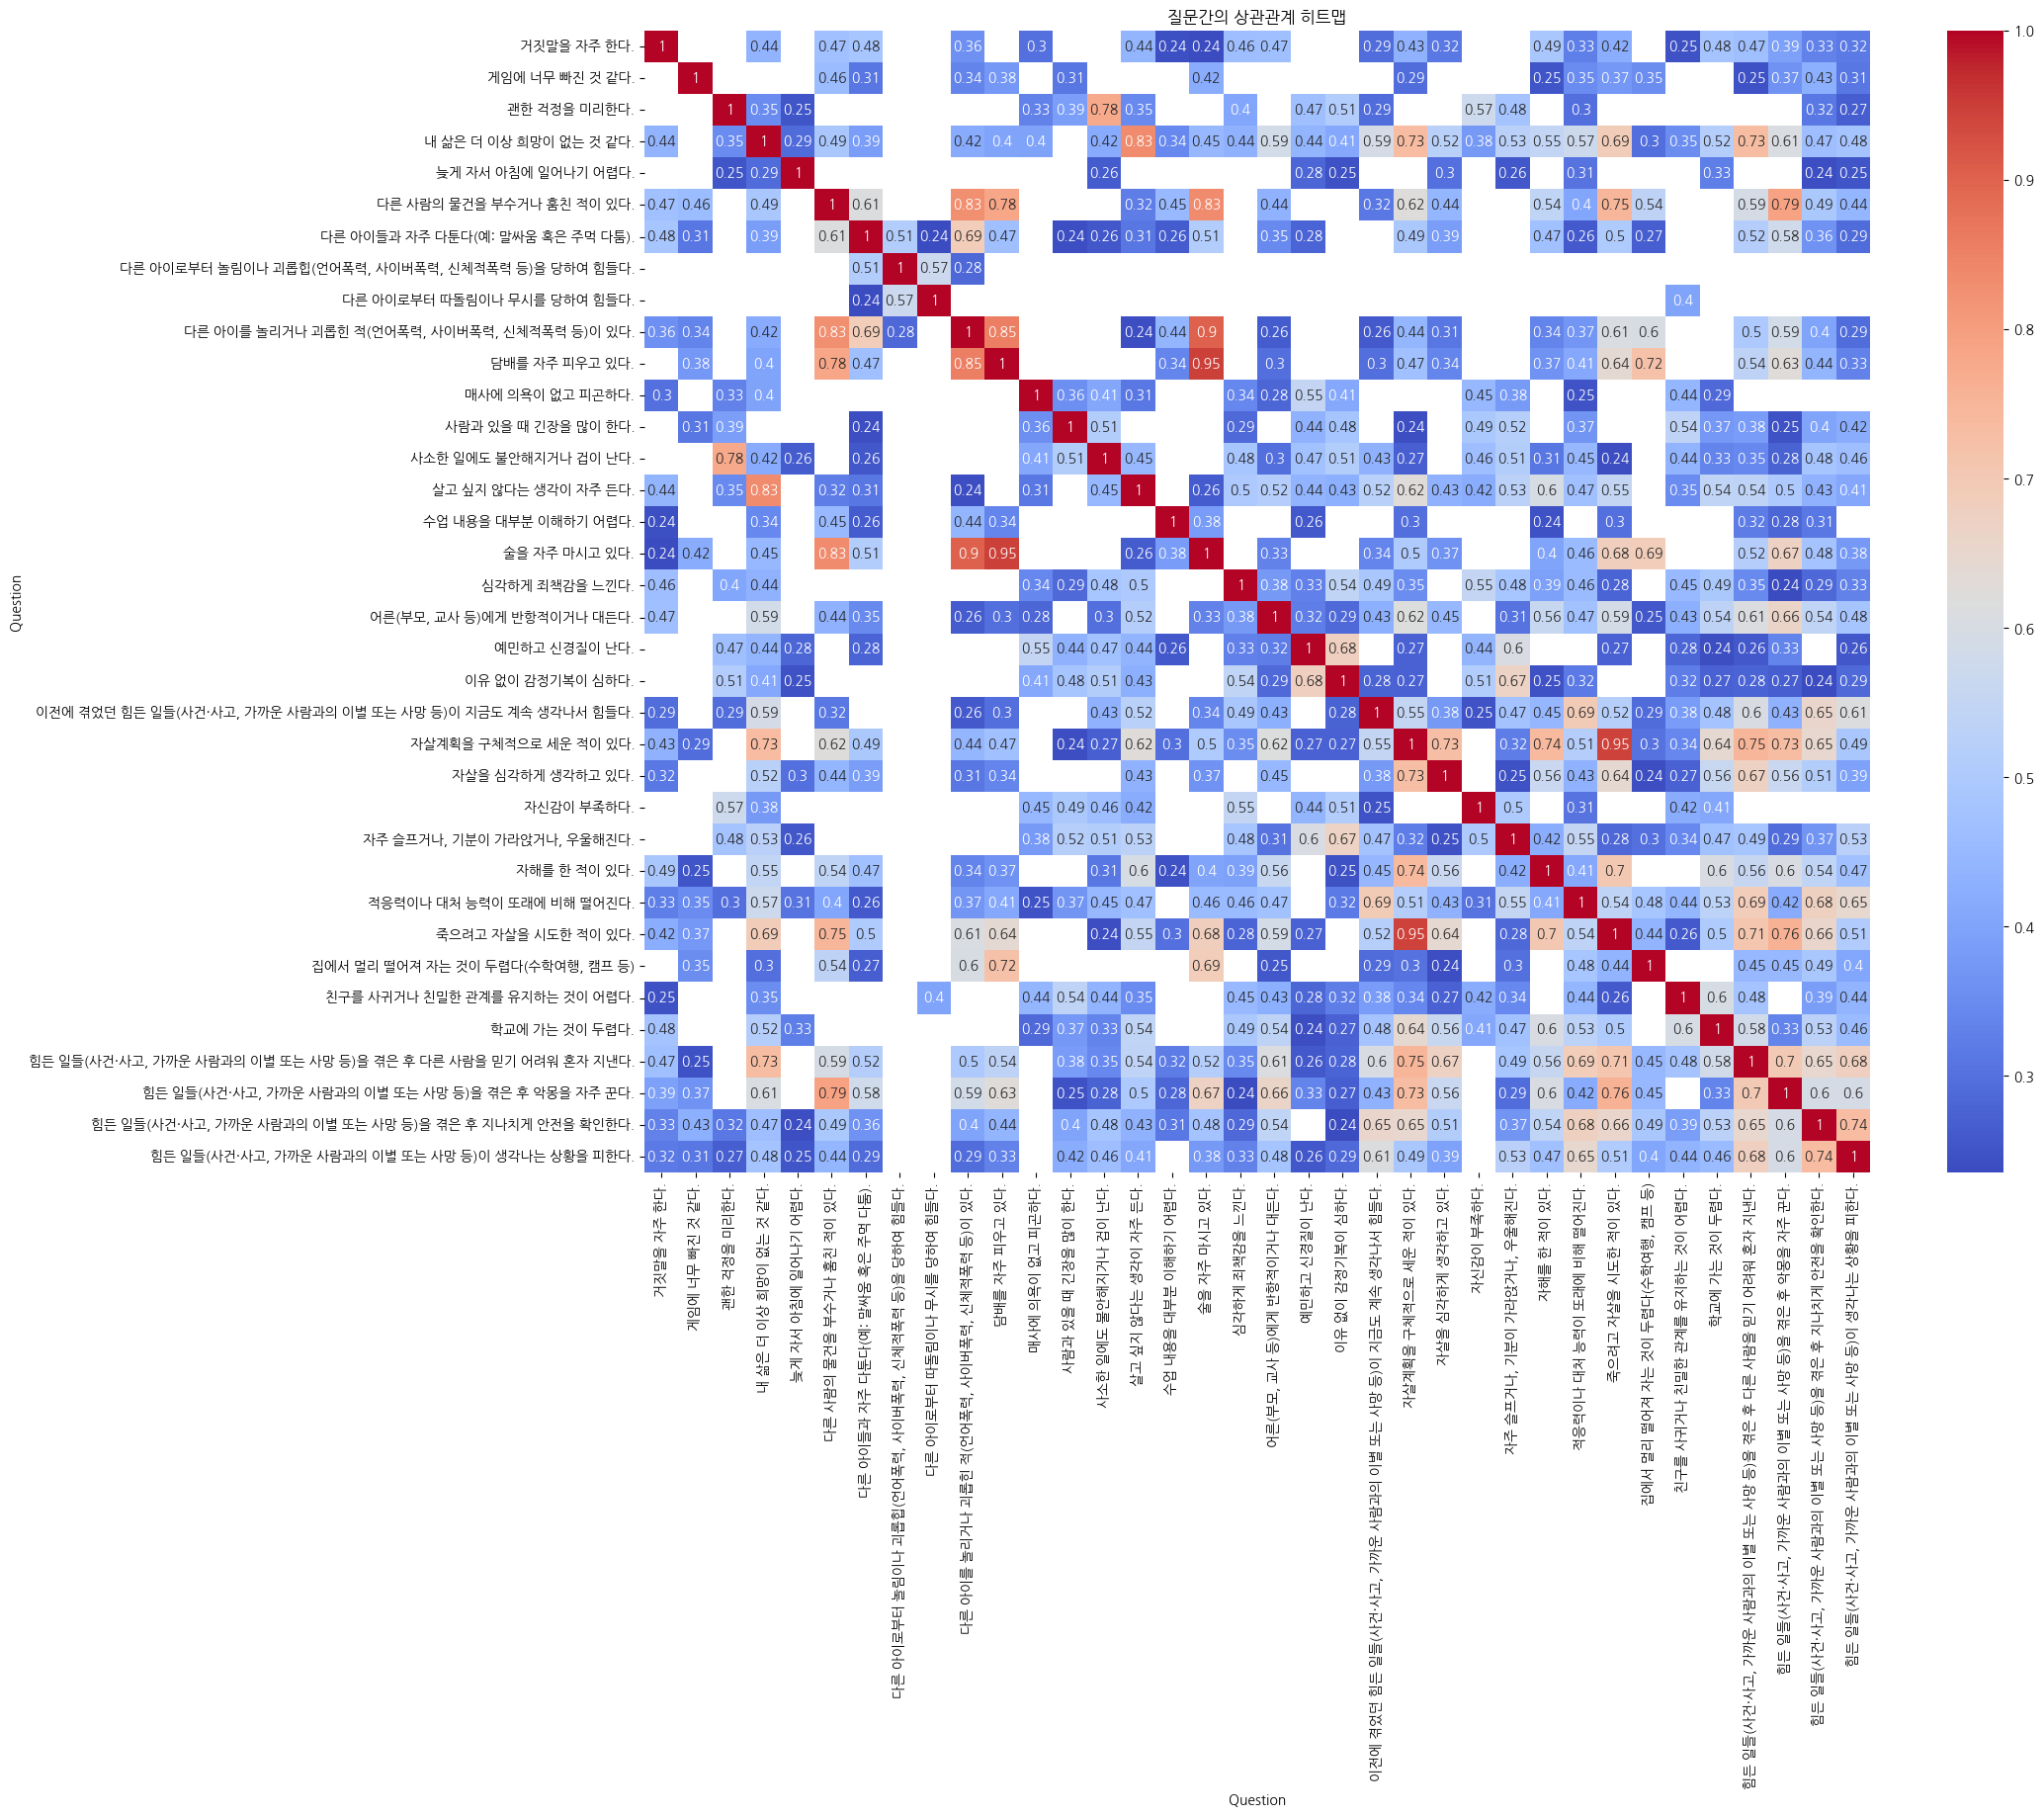

In [10]:
import seaborn as sns

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm")
plt.title("질문간의 상관관계 히트맵")
plt.show()

In [8]:
import pandas as pd

# Step 1: Compute mean score per question
question_avg = question_df.groupby(['Type', 'Question'])[
    'Answer'].mean().reset_index(name='QuestionAvg')

# Step 2: Compute mean score per domain (Type)
domain_avg = question_df.groupby(
    'Type')['Answer'].mean().reset_index(name='DomainAvg')

# Step 3: Merge and compute contribution ratio
contrib_df = pd.merge(question_avg, domain_avg, on='Type')
contrib_df['ContributionRatio'] = contrib_df['QuestionAvg'] / \
    contrib_df['DomainAvg']

# Step 4: Sort
contrib_df = contrib_df.sort_values(
    ['Type', 'ContributionRatio'], ascending=[True, False])

# Display
contrib_df

,Type,Question,QuestionAvg,DomainAvg,ContributionRatio
0,불안 및 우울 문제,괜한 걱정을 미리한다.,1.711864,1.108051,1.544933
1,불안 및 우울 문제,매사에 의욕이 없고 피곤하다.,1.203390,1.108051,1.086042
3,불안 및 우울 문제,사소한 일에도 불안해지거나 겁이 난다.,1.186441,1.108051,1.070746
6,불안 및 우울 문제,이유 없이 감정기복이 심하다.,1.067797,1.108051,0.963671
5,불안 및 우울 문제,예민하고 신경질이 난다.,1.050847,1.108051,0.948375
7,불안 및 우울 문제,"자주 슬프거나, 기분이 가라앉거나, 우울해진다.",0.966102,1.108051,0.871893
4,불안 및 우울 문제,심각하게 죄책감을 느낀다.,0.864407,1.108051,0.780115
2,불안 및 우울 문제,사람과 있을 때 긴장을 많이 한다.,0.813559,1.108051,0.734226
10,심리외상 문제,"이전에 겪었던 힘든 일들(사건·사고, 가까운 사람과의 이별 또는 사망 등)이 지금도...",0.576271,0.290557,1.983333
14,심리외상 문제,"힘든 일들(사건·사고, 가까운 사람과의 이별 또는 사망 등)이 생각나는 상황을 피한다.",0.559322,0.290557,1.925000


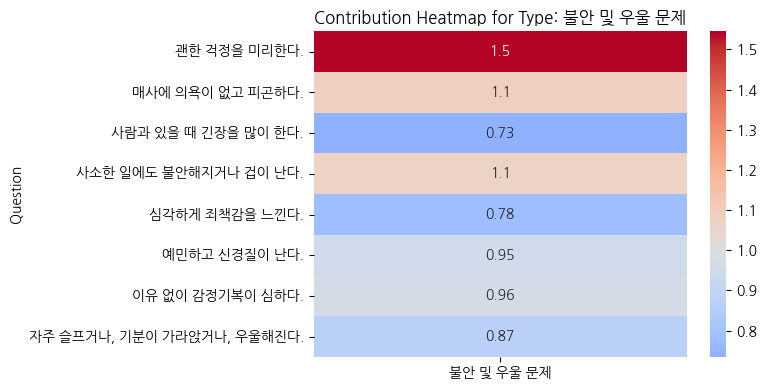

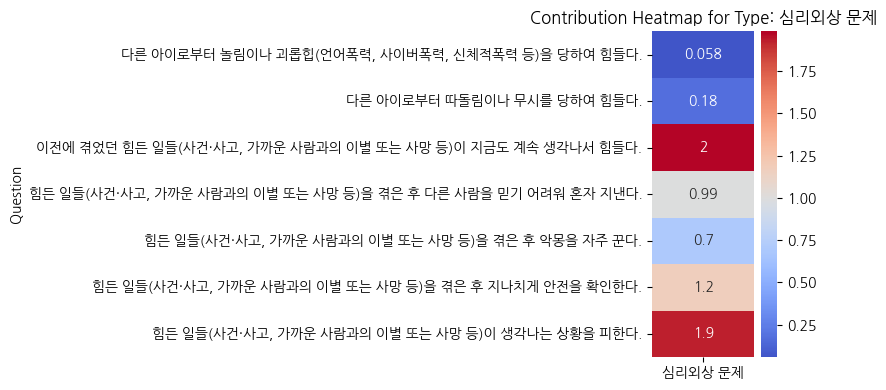

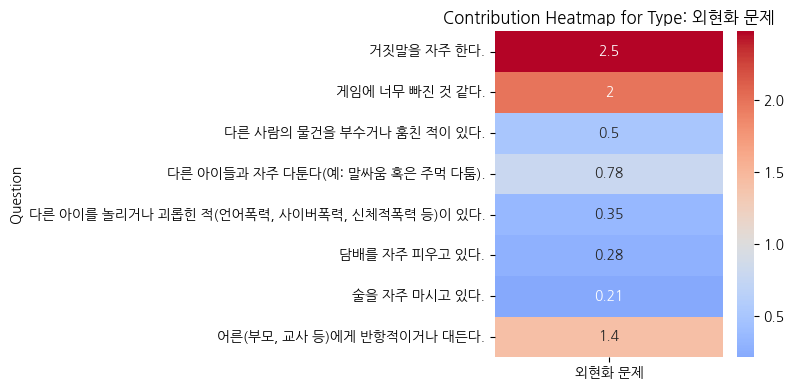

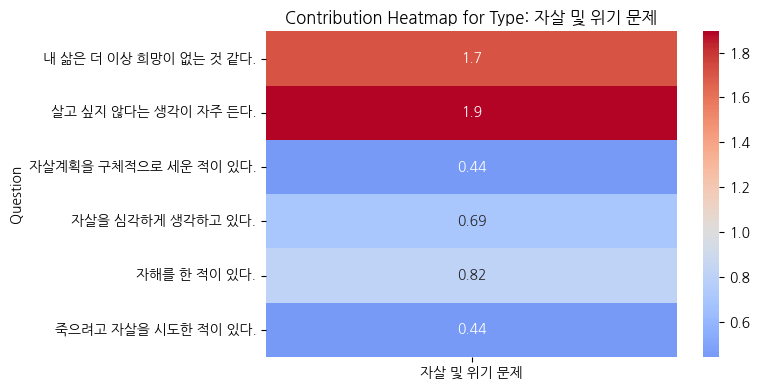

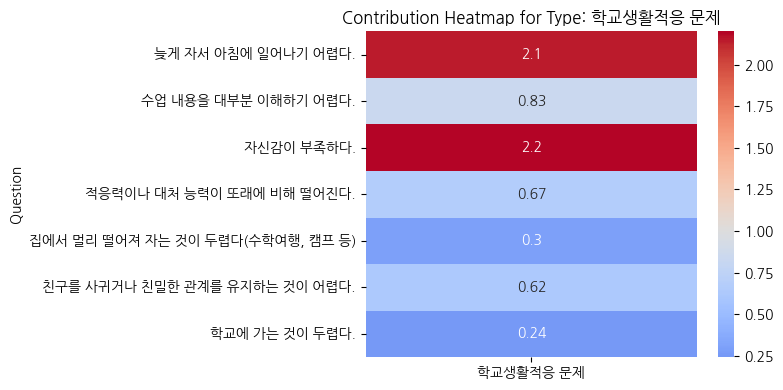

In [9]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Group data for plotting
type_groups = contrib_df.groupby("Type")

# Set up heatmaps per Type
figures = []
for type_name, group in type_groups:
    plt.figure(figsize=(8, max(4, len(group) * 0.3)))
    pivot_data = group.pivot(
        index="Question", columns="Type", values="ContributionRatio")
    sns.heatmap(pivot_data, annot=True, cmap="coolwarm", center=1, cbar=True)
    plt.title(f"Contribution Heatmap for Type: {type_name}")
    plt.xlabel("")
    plt.ylabel("Question")
    plt.tight_layout()
    figures.append(plt.gcf())
    plt.close()

# Display all heatmaps without overwriting
for fig in figures:
    display(fig)